In [1]:
import pandas as pd
import numpy as np

import re
import string
from matplotlib import pyplot as plt
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import losses
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization
from tensorflow.keras.layers.experimental.preprocessing import StringLookup

In [4]:
articles = pd.read_csv("advanced_trainset.csv")

In [5]:
articles.head()

,Sentence,Sentiment
0,According to the Finnish-Russian Chamber of Co...,neutral
1,The Swedish buyout firm has sold its remaining...,neutral
2,$SPY wouldn't be surprised to see a green close,positive
3,Shell's $70 Billion BG Deal Meets Shareholder ...,negative
4,SSH COMMUNICATIONS SECURITY CORP STOCK EXCHANG...,negative


In [6]:
import nltk
from nltk.corpus import stopwords
from string import punctuation
import re
nltk.download('stopwords')
stops = set(stopwords.words('english'))
stops.add("'s")
stop.remove("not")

def clean(sentence):
    # delete stopwords
    temp = " ".join(filter(lambda x: x not in stops, sentence.split()))
    # Remove punctuation
    temp = temp.translate(str.maketrans('', '', punctuation))
    # Delete short words with 3 or less characters
    temp = (lambda x: ' '.join([w for w in x.split() if len(w) > 3]))(temp)
    # Change all to lower case
    temp = temp.lower()
    # Delete numbers
    temp = re.sub(r'[0-9]', "", temp)
    # Delete excessive spaces and return
    return re.sub("  ", " ", temp)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\wmy\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [9]:
articles["Sentence"] = articles["Sentence"].apply(clean)
articles_single = articles.copy()

In [12]:
le = LabelEncoder()
articles_single["Sentiment"] = le.fit_transform(articles_single["Sentiment"])

In [13]:
articles_single.head()

,Sentence,Sentiment
0,according finnishrussian chamber commerce majo...,1
1,swedish buyout firm sold remaining percent sta...,1
2,surprised green close,2
3,shells billion deal meets shareholder skepticism,0
4,communications security corp stock exchange re...,0


(array([ 636.,    0.,    0.,    0.,    0., 2363.,    0.,    0.,    0.,
        1383.]),
 array([0. , 0.2, 0.4, 0.6, 0.8, 1. , 1.2, 1.4, 1.6, 1.8, 2. ]),
 <BarContainer object of 10 artists>)

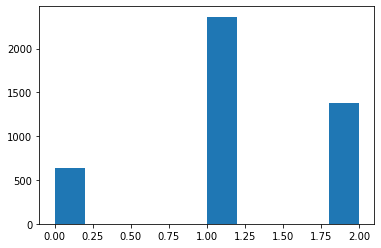

In [30]:
plt.hist(articles_single.Sentiment)

In [18]:
data = tf.data.Dataset.from_tensor_slices((articles_single["Sentence"], articles_single["Sentiment"]))
data = data.shuffle(buffer_size = len(data))

In [72]:
train_size = int(0.7*len(data))
val_size   = int(0.1*len(data))

train = data.take(train_size)
val   = data.skip(train_size).take(val_size)
test  = data.skip(train_size + val_size)

In [20]:
len(train), len(val), len(test)

(3067, 438, 877)

In [21]:
def standardization(input_data):
    lowercase = tf.strings.lower(input_data)
    no_punctuation = tf.strings.regex_replace(lowercase,
                                  '[%s]' % re.escape(string.punctuation),'')
    return no_punctuation 

In [22]:
# only the top distinct words will be tracked
max_tokens = 2000

# each headline will be a vector of length 25
sequence_length = 25

vectorize_layer = TextVectorization(
    standardize=standardization,
    max_tokens=max_tokens, # only consider this many words
    output_mode='int',
    output_sequence_length=sequence_length) 

In [23]:
headlines = train.map(lambda x, y: x)
vectorize_layer.adapt(headlines)

In [24]:
def vectorize_headline(text, label):
    text = tf.expand_dims(text, -1)
    return vectorize_layer(text), [label]

train_vec = train.map(vectorize_headline)
val_vec = val.map(vectorize_headline)
test_vec = test.map(vectorize_headline)

In [39]:
model2 = tf.keras.Sequential([
    layers.Embedding(max_tokens, output_dim = 64, name="embedding"),
    layers.Dropout(0.2),
    layers.Bidirectional(layers.LSTM(64, return_sequences=True)),
    layers.Bidirectional(layers.LSTM(32)),
    layers.Dense(64, activation='relu'),  
    layers.Dropout(0.5),
    layers.Dense(3)]
)

In [40]:
model2.compile(loss=losses.SparseCategoricalCrossentropy(from_logits=True),
               optimizer='adam', 
               metrics=['accuracy'])

In [41]:
history2 = model2.fit(train_vec, epochs = 20, validation_data = val_vec)

Epoch 1/20
3067/3067 [==============================] - 63s 19ms/step - loss: 0.9233 - accuracy: 0.5761 - val_loss: 0.7745 - val_accuracy: 0.6986
Epoch 2/20
3067/3067 [==============================] - 57s 19ms/step - loss: 0.7321 - accuracy: 0.6889 - val_loss: 0.5919 - val_accuracy: 0.7260
Epoch 3/20
3067/3067 [==============================] - 57s 19ms/step - loss: 0.5983 - accuracy: 0.7483 - val_loss: 0.5503 - val_accuracy: 0.7740
Epoch 4/20
3067/3067 [==============================] - 57s 18ms/step - loss: 0.5421 - accuracy: 0.7740 - val_loss: 0.4045 - val_accuracy: 0.8242
Epoch 5/20
3067/3067 [==============================] - 58s 19ms/step - loss: 0.4498 - accuracy: 0.8037 - val_loss: 0.3814 - val_accuracy: 0.8333
Epoch 6/20
3067/3067 [==============================] - 54s 18ms/step - loss: 0.3964 - accuracy: 0.8314 - val_loss: 0.3017 - val_accuracy: 0.8767
Epoch 7/20
3067/3067 [==============================] - 57s 19ms/step - loss: 0.3810 - accuracy: 0.8311 - val_loss: 0.3282 -

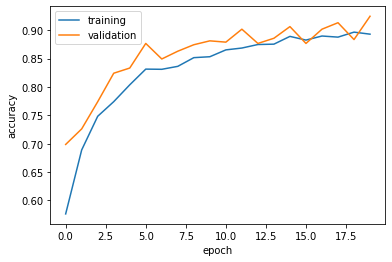

In [42]:
from matplotlib import pyplot as plt
plt.plot(history2.history["accuracy"], label = "training")
plt.plot(history2.history["val_accuracy"], label = "validation")
plt.gca().set(xlabel = "epoch", ylabel = "accuracy")
plt.legend()

In [43]:
model2.evaluate(test_vec)

877/877 [==============================] - 4s 4ms/step - loss: 0.1574 - accuracy: 0.9042


[0.1574002057313919, 0.9042189121246338]

Test on the real testset provided. We are unable to obtain an accuracy on this dataset, but it should be around 0.9 based on validation set and test set extracted from advanced_trainset.csv.

In [80]:
test_real = pd.read_csv("advanced_testset.csv")
test_real.head()

,Sentence
0,Earnings per share ( EPS ) dropped to EUR 0.21...
1,$SONC Amazing run since middle of March - obvi...
2,"Ruukki Romania , the local arm of Finnish meta..."
3,Self-service and automation are in a bigger ro...
4,Alma Media 's operating profit amounted to EUR...


In [81]:
def convert_to_sentiment(x):
    temp = np.argmax(x)
    return "positive" if temp == 2 else "neutral" if temp == 1 else "negative"

In [82]:
a = model2.predict(vectorize_layer(test_real.Sentence))

In [83]:
test_real["Sentiment"] = list(map(convert_to_sentiment, a))
test_real

,Sentence,Sentiment
0,Earnings per share ( EPS ) dropped to EUR 0.21...,neutral
1,$SONC Amazing run since middle of March - obvi...,neutral
2,"Ruukki Romania , the local arm of Finnish meta...",positive
3,Self-service and automation are in a bigger ro...,neutral
4,Alma Media 's operating profit amounted to EUR...,neutral
...,...,...
1455,Diluted earnings per share ( EPS ) rose to EUR...,positive
1456,The company is in the process of building a ne...,positive
1457,"Sales climbed 19.2 pct to 1.002 bln eur , surp...",neutral
1458,"Hammerson, JV Partner secure ownership of Irel...",neutral
